In [95]:
import pandas as pd
import itertools
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

class LogicAnalyzer:
    def __init__(self, signals_df):
        # Create a deep copy to ensure immutability
        self._signals_df = signals_df.copy(deep=True)
        self._input_signals = self._get_input_signals()
        self._dependencies = self._create_dependency_graph()
        # Cache ordered signals during initialization
        self._ordered_signals = self._calculate_ordered_signals()
        
    def _get_input_signals(self):
        return self._signals_df[self._signals_df['expression'] == '@input']['signal_name'].tolist()
    
    def _create_dependency_graph(self):
        dependencies = defaultdict(set)
        for _, row in self._signals_df[self._signals_df['expression'] != '@input'].iterrows():
            signal = row['signal_name']
            expr = row['expression']
            for _, sig_row in self._signals_df.iterrows():
                if f"${sig_row['signal_name']}" in expr or (sig_row['alias'] and f"${sig_row['alias']}" in expr):
                    dependencies[signal].add(sig_row['signal_name'])
        return dependencies
    
    def _calculate_ordered_signals(self):
        processed = set(self._input_signals)
        ordered_signals = []
        derived_signals = self._signals_df[self._signals_df['expression'] != '@input']
        
        while len(ordered_signals) < len(derived_signals):
            for _, row in derived_signals.iterrows():
                signal = row['signal_name']
                if signal not in processed and self._dependencies[signal].issubset(processed):
                    ordered_signals.append(row)
                    processed.add(signal)
        return ordered_signals
    
    def evaluate(self, input_values):
        local_dict = dict(zip(self._input_signals, input_values))
        
        for row in self._ordered_signals:
            signal = row['signal_name']
            expression = row['expression']
            
            eval_expr = expression
            for _, sig_row in self._signals_df.iterrows():
                if sig_row['alias']:
                    eval_expr = eval_expr.replace(f"${sig_row['alias']}", sig_row['signal_name'])
                eval_expr = eval_expr.replace(f"${sig_row['signal_name']}", sig_row['signal_name'])
            
            local_dict[signal] = int(eval(eval_expr, {"__builtins__": None}, local_dict))
        
        return local_dict

    def generate(self):
        input_combinations = list(itertools.product([0, 1], repeat=len(self._input_signals)))
        results = [self.evaluate(inputs) for inputs in input_combinations]
        return pd.DataFrame(results)
    def plot_signal_topology(self):
        # Create directed graph
        G = nx.DiGraph()
        
        # Add all signals as nodes
        for _, row in self._signals_df.iterrows():
            signal = row['signal_name']
            alias = row['alias'] if row['alias'] else signal  # Use alias if available, otherwise use signal name
            is_input = row['expression'] == '@input'
            G.add_node(signal, color='lightblue' if is_input else 'lightgreen', label=alias)
        
        # Add edges based on dependencies
        for signal, deps in self._dependencies.items():
            for dep in deps:
                G.add_edge(dep, signal)
        
        # Get topological layers
        layers = []
        remaining_nodes = set(G.nodes())
        while remaining_nodes:
            current_layer = {node for node in remaining_nodes 
                           if not any(pred in remaining_nodes 
                                    for pred in G.predecessors(node))}
            layers.append(list(current_layer))
            remaining_nodes -= current_layer
        
        # Create position dictionary
        pos = {}
        layer_spacing = 1.0
        for i, layer in enumerate(layers):
            y_spacing = 1.0 / (len(layer) + 1)
            for j, node in enumerate(layer):
                pos[node] = (i * layer_spacing, (j + 1) * y_spacing)
        
        # Draw the graph
        plt.figure(figsize=(12, 8))
        
        # Draw nodes and edges
        node_colors = [G.nodes[node]['color'] for node in G.nodes()]
        nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=35)
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000, alpha=0.7)
        
        # Draw labels using aliases
        labels = {node: G.nodes[node]['label'] for node in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels)
        
        plt.title("Signal Dependency Graph")
        plt.axis('off')
        plt.show()
class TimedLogicAnalyzer(LogicAnalyzer):
    def __init__(self, signals_df, rise_times=None, fall_times=None):
        super().__init__(signals_df)
        # Default rise/fall times if not provided
        self._rise_times = rise_times or {sig: 1 for sig in self._signals_df['signal_name']}
        self._fall_times = fall_times or {sig: 1 for sig in self._signals_df['signal_name']}
    
    def calculate_transition_delays(self, input_values_before, input_values_after):
        # Calculate states before and after input change
        state_before = self.evaluate(input_values_before)
        state_after = self.evaluate(input_values_after)
        
        # Initialize delay times dictionary
        delays = {sig: 0 for sig in self._signals_df['signal_name']}
        
        # Set delays for input signals that changed
        for sig, before_val in zip(self._input_signals, input_values_before):
            after_val = input_values_after[self._input_signals.index(sig)]
            if before_val != after_val:
                delays[sig] = self._rise_times[sig] if after_val == 1 else self._fall_times[sig]
        
        # Calculate delays for derived signals
        for row in self._ordered_signals:
            signal = row['signal_name']
            # Find maximum delay from dependencies
            max_dep_delay = 0
            for dep in self._dependencies[signal]:
                if delays[dep] > max_dep_delay:
                    max_dep_delay = delays[dep]
            
            # Add transition time if signal changed
            if state_before[signal] != state_after[signal]:
                transition_time = (self._rise_times[signal] if state_after[signal] == 1 
                                 else self._fall_times[signal])
                delays[signal] = max_dep_delay + transition_time
            else:
                delays[signal] = max_dep_delay
                
        return delays

In [ ]:
test_signals = pd.DataFrame([
    ['A', 'a', '@input'],
    ['B', 'b', '@input'],
    ['C', 'c', '@input'],
    ['Z', 'z', '$Y or $C or $A'],
    ['Y', 'y', '$A and $B'],
    
], columns=['signal_name', 'alias', 'expression'])

generator = LogicAnalyzer(test_signals)
result = generator.generate()

display(result)

,A,B,C,Y,Z
0,0,0,0,0,0
1,0,0,1,0,1
2,0,1,0,0,0
3,0,1,1,0,1
4,1,0,0,0,1
5,1,0,1,0,1
6,1,1,0,1,1
7,1,1,1,1,1


In [96]:
# Create a complex test case with scrambled order and complex dependencies
complex_signals = pd.DataFrame([
    ['G', 'g', '$C or $D'],     # Intentionally placed before its dependencies
    ['K', 'k', '$F and not $G or $J'],
    ['C', 'c', '@input'],
    ['J', 'j', 'not $I'],
    ['A', 'aaa', '@input'],
    ['I', 'i', '$H or $E'],
    ['F', 'f', '$A and $B'],
    ['D', 'd', '@input'],
    ['H', 'h', '$F and $G'],
    ['B', 'b', '@input'],
    ['E', 'e', '@input'],
], columns=['signal_name', 'alias', 'expression'])

In [97]:
complex_generator = TimedLogicAnalyzer(complex_signals)

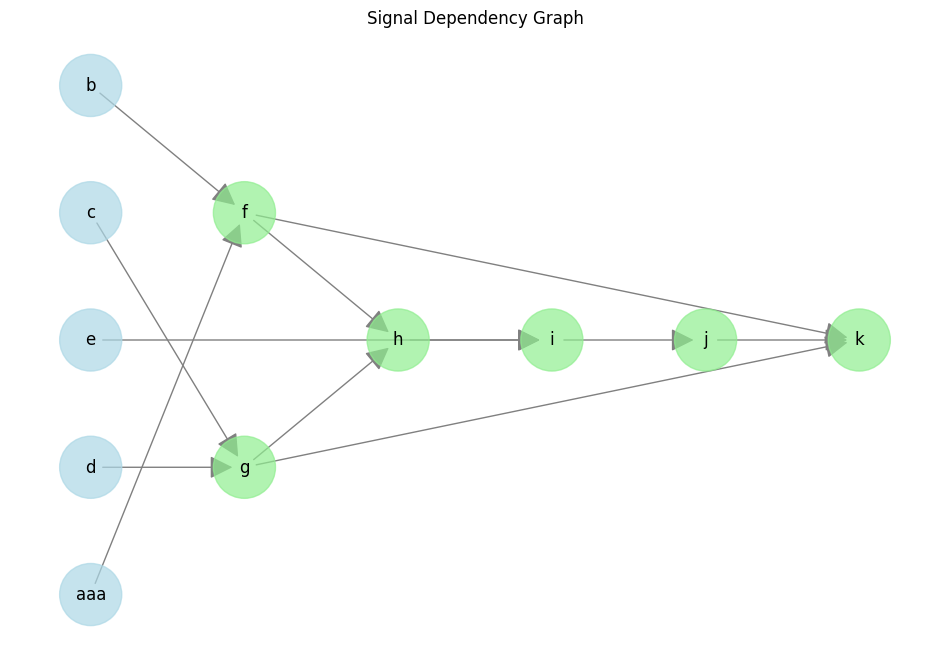

In [98]:
complex_generator.plot_signal_topology()